In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw13.ipynb")

<img style="display: block; margin-left: auto; margin-right: auto" src="./ccsf-logo.png" width="250rem;" alt="The CCSF black and white logo">

# Homework 13: Classification

## References

* [Classification](https://inferentialthinking.com/chapters/17/Classification.html)
* [Updating Predictions](https://inferentialthinking.com/chapters/18/Updating_Predictions.html)
* [`datascience` Documentation](https://datascience.readthedocs.io/)
* [Python Quick Reference](https://ccsf-math-108.github.io/materials-sp24/resources/quick-reference.html)

## Assignment Reminders

- Make sure to run the code cell at the top of this notebook that starts with `# Initialize Otter` to load the auto-grader.
- For all tasks indicated with a 🔎 that you must write explanations and sentences for, provide your answer in the designated space.
- Throughout this assignment and all future ones, please be sure to not re-assign variables throughout the notebook! _For example, if you use `max_temperature` in your answer to one question, do not reassign it later on. Otherwise, you will fail tests that you thought you were passing previously!_
- We encourage you to discuss this assignment with others but make sure to write and submit your own code. Refer to the syllabus to learn more about how to learn cooperatively.
- Unless you are asked otherwise, use the non-interactive visualizations when asked to produce a visualization for a task.
- View the related <a href="https://ccsf.instructure.com" target="_blank">Canvas</a> Assignment page for additional details.

Run the following code cell to import the tools for this assignment.

In [2]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

This assignment is about k-Nearest Neighbors classification (kNN). Since this topic is covered in depth in Project 3, the purpose of this homework is to reinforce the basics of this method. You can and should reuse a lot of code that you wrote for Project 3 for this homework, or use code from this homework on Project 3!

## Bay Area School Coordinates with Classification


Carol is trying classify students as either attendees of UC Berkeley or as attendees of Stanford. To classify the students, Carol has access to the coordinates of the location they live during the school year. First, load in the `coordinates` table.

In [3]:
# Just run this cell!
coordinates = Table.read_table('coordinates.csv')
coordinates.show(5)

latitude,longitude,school
37.8693,-122.255,Berkeley
37.8651,-122.256,Berkeley
37.8661,-122.254,Berkeley
37.868,-122.26,Berkeley
37.8683,-122.257,Berkeley


As usual, let's investigate our data visually before performing any kind of numerical analysis.

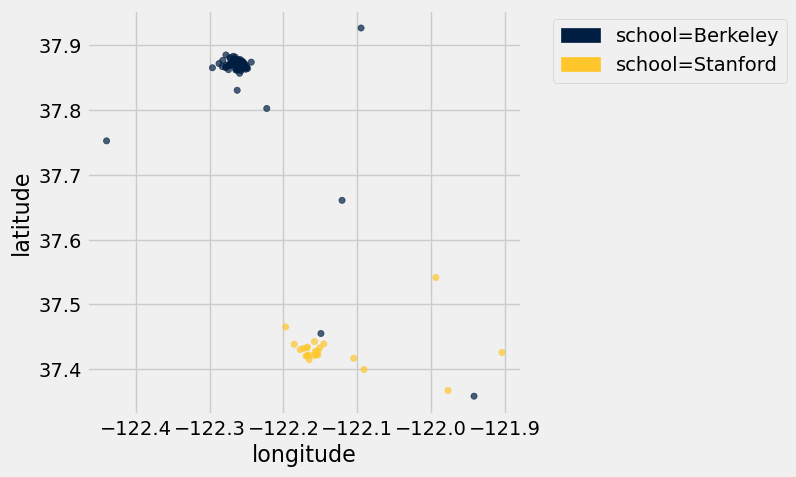

In [4]:
# Just run this cell!
coordinates.scatter("longitude", "latitude", group="school")

The locations of the points on this scatter plot might be familiar - run the following cell to see what they correspond to.

In [5]:
# Just run this cell!
colors = {"Berkeley":"blue", "Stanford":"red"}
t = Table().with_columns("lat", coordinates.column(0), 
                                      "lon", coordinates.column(1), 
                                      "color", coordinates.apply(colors.get, 2)
                        )
Circle.map_table(t, area=5, fill_opacity=1)

### Task 01 📍

Let's begin implementing the k-Nearest Neighbors algorithm. Define the `distance` function, which takes in two arguments: an array of numerical features, and a different array of numerical features. The function should return the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the two arrays. Euclidean distance is often referred to as the straight-line distance formula that you may have learned previously.



_Points:_ 2

In [6]:
def distance(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    dist = np.sqrt(np.sum((arr1 - arr2) ** 2))
    return dist

# Don't change/delete the code below in this cell
distance_example = distance(make_array(1, 2, 3), make_array(4, 5, 6))
distance_example


5.196152422706632

In [7]:
grader.check("task_01")

task_01 results: All test cases passed!
task_01 - 1 message: ✅ distance_example is a float.
task_01 - 2 message: ✅ distance_example seems correct.

### Splitting the dataset

We'll do 2 different kinds of things with the `coordinates` dataset:
1. We'll build a classifier using coordinates for which we know the associated label; this will teach it to recognize labels of similar coordinate values. This process is known as *training*.
2. We'll evaluate or *test* the accuracy of the classifier we build on data we haven't seen before.

For reasons discussed in lecture and the textbook, we want to use separate datasets for these two purposes.  So we split up our one dataset into two.

#### Task 02 📍

Next, let's split our dataset into a training set and a test set. Since `coordinates` has $100$ rows, let's create a training set with the first 75 rows and a test set with the remaining 25 rows. Remember that assignment to each group should be random, so we should shuffle the table first.

*Hint: as a first step we can shuffle all the rows, then use the* `tbl.take` *function to split up the rows for each table*



_Points:_ 3

In [8]:
shuffled_table = coordinates.sample(with_replacement=False)
train = shuffled_table.take(np.arange(75))
test = shuffled_table.take(np.arange(75, 100))

print("Training set:\t",   train.num_rows, "examples")
print("Test set:\t",       test.num_rows, "examples")
train.show(5), test.show(5);


Training set:	 75 examples
Test set:	 25 examples


latitude,longitude,school
37.8563,-122.259,Berkeley
37.3587,-121.942,Berkeley
37.4171,-122.105,Stanford
37.8613,-122.265,Berkeley
37.432,-122.173,Stanford


latitude,longitude,school
37.8688,-122.255,Berkeley
37.8615,-122.263,Berkeley
37.8825,-122.268,Berkeley
37.8619,-122.274,Berkeley
37.8646,-122.25,Berkeley


In [9]:
grader.check("task_02")

task_02 results: All test cases passed!
task_02 - 1 message: ✅ train has the correct number of rows.
task_02 - 2 message: ✅ test has the correct number of rows.
task_02 - 3 message: ✅ The sum of the number of rows in the training set and test set gives the total number of rows in coordinates.

### Task 03 📍

Assign `features` to an array of the labels of the features from the `coordinates` table.

*Hint: which of the column labels in the `coordinates` table are the features, and which of the column labels correspond to the class we're trying to predict?*


_Points:_ 2

In [10]:
features = coordinates.select('latitude', 'longitude').to_array()
features

array([( 37.869304, -122.254946), ( 37.865051, -122.255582),
       ( 37.866116, -122.253733), ( 37.868049, -122.259579),
       ( 37.868286, -122.256581), ( 37.866274, -122.251185),
       ( 37.870692, -122.252334), ( 37.876214, -122.259579),
       ( 37.87795 , -122.262278), ( 37.876766, -122.265925),
       ( 37.880474, -122.272621), ( 37.869733, -122.273603),
       ( 37.866569, -122.282859), ( 37.86795 , -122.254217),
       ( 37.863865, -122.262234), ( 37.867939, -122.257095),
       ( 37.875321, -122.263319), ( 37.872008, -122.268462),
       ( 37.868754, -122.255189), ( 37.866336, -122.256663),
       ( 37.866037, -122.261542), ( 37.881261, -122.265399),
       ( 37.87344 , -122.243655), ( 37.863308, -122.255354),
       ( 37.866849, -122.254319), ( 37.868862, -122.254707),
       ( 37.872883, -122.254221), ( 37.87437 , -122.2554  ),
       ( 37.87739 , -122.258311), ( 37.876815, -122.26601 ),
       ( 37.875055, -122.267958), ( 37.872628, -122.270658),
       ( 37.865946, -122

In [11]:
grader.check("task_03")

task_03 results:
    task_03 - 1 message: ❌ features should be an array with 2 items.

    task_03 - 1 result:
        ❌ Test case failed
        Trying:
            isinstance(features, np.ndarray) and len(features) == 2
        Expecting:
            True
        **********************************************************************
        Line 1, in task_03 0
        Failed example:
            isinstance(features, np.ndarray) and len(features) == 2
        Expected:
            True
        Got:
            False

### Task 04 📍

Now define the `classify` function. This function should take in a `row` from a table like `test` and classify it based on the data in `train` using the `k`-Nearest Neighbors based on the correct `features`.

*Hint: use the `row_to_array` function we defined for you to convert rows to arrays of features so that you can use the `distance` function you defined earlier.*

*Hint 2: the skeleton code we provided iterates through each row in the training set*


_Points:_ 2

In [12]:
def row_to_array(row, features):
    arr = make_array()
    for feature in features:
        arr = np.append(arr, row.item(feature))
    return arr

def classify(row, k, train):
    features = ['latitude', 'longitude'] 
    test_row_features_array = row_to_array(row, features)
    distances = make_array()

    for train_row in train.rows:
        train_row_features_array = row_to_array(train_row, features)
        row_distance = distance(test_row_features_array, train_row_features_array)
        distances = np.append(distances, row_distance)
    
    train_with_distances = train.with_column('Distance', distances).sort('Distance')
    nearest_neighbors = train_with_distances.take(np.arange(k))
    most_common_label = nearest_neighbors.group('school').sort('count', descending=True).column('school').item(0)
    return most_common_label

# Don't modify/delete the code below
first_test = classify(test.row(0), 5, train)
first_test

'Berkeley'

In [13]:
grader.check("task_04")

task_04 results: All test cases passed!
task_04 - 1 message: ✅ first_test is a string.
task_04 - 2 message: ✅ classify correctly classified the row we tested.

### Task 05 📍

1. Define the function `three_classify` that takes a `row` from `test` as an argument and classifies the row based on using 3-Nearest Neighbors.
2. Use this function to find the `accuracy` of a 3-NN classifier on the `test` set. `accuracy` should be a proportion (not a percentage) of the schools that were correctly predicted.

*Hint: you should be using a function you just created!*

*Note: Usually before using a classifier on a test set, we'd classify first on a "validation" set, which we then can modify our training set again if need be, before actually testing on the test set. You don't need to do that for this question, but you will learn about this more in an advanced course.*


_Points:_ 3

In [14]:
def three_classify(row):
    return classify(row, 3, train)

test_with_prediction = test.with_column('predicted_school', test.apply(three_classify))
labels_correct = sum(test_with_prediction.column('school') == test_with_prediction.column('predicted_school'))
accuracy = labels_correct / test.num_rows

accuracy

0.95999999999999996

In [15]:
grader.check("task_05")

task_05 results: All test cases passed!
task_05 - 1 message: ✅ classify and three_classify seem to provide the same result for the row we tested.
task_05 - 2 message: ✅ accuracy is a number between 0 and 1.

### Task 06 📍

There are 77 rows of Berkeley students and 23 rows of Stanford students in the `coordinates` table. If we used the entire `coordinates` table as the train set, what is the smallest value of k that would ensure that a k-Nearest Neighbor classifier would always predict Berkeley as the class? Assign the value to `k`.


_Points:_ 2

In [18]:
k = 24
k

24

In [19]:
grader.check("task_06")

task_06 results: All test cases passed!
task_06 - 1 message: ✅ k is an integer.

### Task 07 📍🔎

<!-- BEGIN QUESTION -->

Why do we divide our data into a training and test set? Should we use our test set to find the best possible number of neighbors for a k-NN classifer? What is the point of a test set, and why do we only want to use the test set once? Explain. 


_Points:_ 2

Data is divided into training and test sets to assess model performance. The test set should not be used for tuning model parameters such as the number of neighbors in k-NN. It's used for unbiased evaluation of how well the model generalizes to new data.

<!-- END QUESTION -->

### Task 08 📍🔎

<!-- BEGIN QUESTION -->

Why do we use an odd-numbered `k` in k-NN? Explain.



_Points:_ 2

An odd-numbered k in k-NN is used to prevent ties during the class label voting process.

<!-- END QUESTION -->

## (OPTIONAL) k-NN for Non-Binary Classification

**THIS IS OPTIONAL**. There are no autograder tests for this/code for you to write. It just relies on the function `classify` in Task 04.

In this class, we have taught you how to use the kNN algorithm to classify data as one of two classes. However, much of the data you will encounter in the real world will not fall nicely into one of two categories. 

How can we classify data with non-binary classes? It turns out we can still use kNN! That is, we find the distance between a point and all its neighbors, find the nearest neighbors, and take a majority vote among the neighbors to determine this point's class. 

The only difference is that now the neighboring points have more than two possible classes. This does introduce difficulty because now we have no way of guaranteeing that we will not encounter ties between classes. In the case that we do encounter a tie, we can just arbitrarily choose one of the classes.

In fact, you don't even have to modify the code you wrote before at all to enable multi-class classification!

Let's add some more data to our train table, this time for another class of students, students at San Jose Community College (SJCC).

In [ ]:
coordinates_multi = coordinates.with_rows([
                              [37.304346, -121.915401, "SJCC"],
                              [37.316275, -121.913879, "SJCC"],
                              [37.409435, -121.951379, "SJCC"],
                              [37.349387, -121.960771, "SJCC"],
                              [37.329083, -121.928479, "SJCC"],
                              [37.313017, -121.866730, "SJCC"],
                              [37.346525, -121.894767, "SJCC"],
                              [37.364157, -121.955717, "SJCC"],
                              [37.383362, -121.925776, "SJCC"],
                              [37.329545, -121.880639, "SJCC"]                             
])

In [ ]:
classify(coordinates_multi.row(0), 5, coordinates_multi)

In [ ]:
classify(coordinates_multi.row(91), 5, coordinates_multi)

In [ ]:
classify(coordinates_multi.row(105), 5, coordinates_multi)

Our classifier can classify rows as belonging to one of three classes!

Classification is one of the most important fields in statistics, data science, and machine learning. There are thousands of different classification algorithms and modifications of algorithms! There are many that you'll learn if you continue down the path of becoming a data scientist!

## Submit your Homework to Canvas

Once you have finished working on the homework tasks, prepare to submit your work in Canvas by completing the following steps.

1. In the related Canvas Assignment page, check the rubric to know how you will be scored for this assignment.
2. Double-check that you have run the code cell near the end of the notebook that contains the command `"grader.check_all()"`. This command will run all of the run tests on all your responses to the auto-graded tasks marked with 📍.
3. Double-check your responses to the manually graded tasks marked with 📍🔎.
3. Select the menu item "File" and "Save Notebook" in the notebook's Toolbar to save your work and create a specific checkpoint in the notebook's work history.
4. Select the menu items "File", "Download" in the notebook's Toolbar to download the notebook (.ipynb) file. 
5. In the related Canvas Assignment page, click Start Assignment or New Attempt to upload the downloaded .ipynb file.

**Keep in mind that the auto-grader does not always check for correctness. Sometimes it just checks for the format of your answer, so passing the auto-grader for a task does not mean you got the answer correct for that task.**

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [20]:
grader.check_all()

task_01 results: All test cases passed!
task_01 - 1 message: ✅ distance_example is a float.
task_01 - 2 message: ✅ distance_example seems correct.

task_02 results: All test cases passed!
task_02 - 1 message: ✅ train has the correct number of rows.
task_02 - 2 message: ✅ test has the correct number of rows.
task_02 - 3 message: ✅ The sum of the number of rows in the training set and test set gives the total number of rows in coordinates.

task_03 results:
    task_03 - 1 message: ❌ features should be an array with 2 items.

    task_03 - 1 result:
        ❌ Test case failed
        Trying:
            isinstance(features, np.ndarray) and len(features) == 2
        Expecting:
            True
        **********************************************************************
        Line 1, in task_03 0
        Failed example:
            isinstance(features, np.ndarray) and len(features) == 2
        Expected:
            True
        Got:
            False

task_04 results: All test cases 